In [1]:
import tensorflow as tf

import os
import collections
import shutil
import time

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
tf.test.gpu_device_name()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12561290029152964467
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6667611669
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10228132815029071649
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


'/device:GPU:0'

## Parameters

In [3]:
dataset_path = "Datasets/cityscapes/"

In [4]:
buffer_size = 1500
batch_size = 14
img_height = 256
img_width = 256

## Dataset load and augmentation

In [5]:
def load_img(image_pth):
    """Load the image file."""
    image = tf.io.read_file(image_pth)
    image = tf.image.decode_jpeg(image)
    
    w = tf.shape(image)[1]
    w = w // 2
    
    real_img = image[:, :w, :]
    real_img = tf.cast(real_img, tf.float32)
    
    input_img = image[:, w:, :]
    input_img = tf.cast(input_img, tf.float32)
    
    return input_img, real_img
    #return real_img, input_img

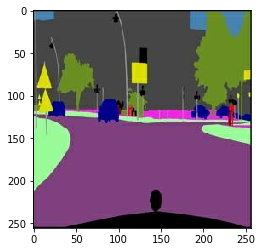

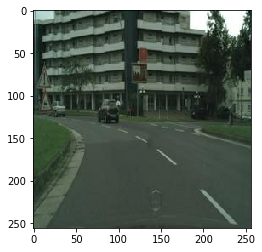

In [6]:
inp, re = load_img(dataset_path + "train/1.jpg")

plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [7]:
def resize_img(input_img, real_img, height, width):
    """Resize the image."""
    input_img = tf.image.resize(input_img, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_img = tf.image.resize(real_img, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return input_img, real_img

In [8]:
def random_crop(input_img, real_img):
    """Randomly crop the image."""
    stacked_img = tf.stack([input_img, real_img], axis=0)
    cropped_img = tf.image.random_crop(stacked_img, size=[2, img_height, img_width, 3])
    
    return cropped_img[0], cropped_img[1]

In [9]:
# Normalize [-1, 1]
def normalize(input_img, real_img):
    input_img = (input_img / 127.5) - 1.0
    real_img = (real_img / 127.5) - 1.0
    
    return input_img, real_img

In [10]:
# tf.function add the function to graph so can be run on GPU or TPU
@tf.function()
def random_jitter(input_img, real_img):
    """Data augmentation for the photos."""
    input_img, real_img = resize_img(input_img, real_img, 286, 286)
    input_img, real_img = random_crop(input_img, real_img)
    
    # Mirroring with chance of 0.5
    if tf.random.uniform(()) > 0.5:
        input_img = tf.image.flip_left_right(input_img)
        real_img = tf.image.flip_left_right(real_img)
        
    return input_img, real_img

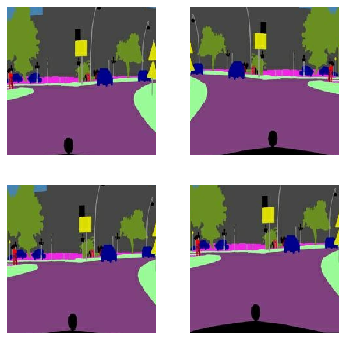

In [11]:
# Test the random jitter function
plt.figure(figsize=(6, 6))
for i in range(4):
    m_inp, m_re = random_jitter(inp, re)
    plt.subplot(2, 2, i+1)
    plt.imshow(m_inp/255.0)
    plt.axis("off")
plt.show()

In [12]:
def load_img_train(img_file):
    """Load and augment training images."""
    input_img, real_img = load_img(img_file)
    input_img, real_img = random_jitter(input_img, real_img)
    input_img, real_img = normalize(input_img, real_img)
    
    return input_img, real_img

In [13]:
def load_img_test(img_file):
    """Load and augment test images."""
    input_img, real_img = load_img(img_file)
    input_img, real_img = resize_img(input_img, real_img, img_height, img_width)
    input_img, real_img = normalize(input_img, real_img)
    
    return input_img, real_img

In [14]:
train_dataset = tf.data.Dataset.list_files(dataset_path + 'train/*.jpg')
train_dataset = train_dataset.map(load_img_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset

<DatasetV1Adapter shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>

In [15]:
test_dataset = tf.data.Dataset.list_files(dataset_path + 'val/*.jpg')
test_dataset = test_dataset.map(load_img_test)
test_dataset = test_dataset.batch(batch_size)

## Architecture

In [16]:
output_channels = 3

In [17]:
def downsample(filters, size, apply_batchnorm=True):
    """Encoder block."""
    # Initialize weights
    initializer = tf.random_normal_initializer(0.0, 0.02)
    
    result = tf.keras.Sequential()
    # Add Conv2D layer
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                              kernel_initializer=initializer, use_bias=False))
    # Add Batch Normalization layer
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    # Add Leaky ReLU layer
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

In [18]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(m_inp, 0))
print(down_result.shape)

(1, 128, 128, 3)


In [19]:
def upsample(filters, size, apply_dropout=False, use_transpose_conv=True):
    """Decoder block."""
    # Initialize weights
    initializer = tf.random_normal_initializer(0.0, 0.02)
    
    result = tf.keras.Sequential()
    # Add Conv Transpose layer or Upsample layer
    # Try PixelShuffle ICNR instead of upsample
    if use_transpose_conv:
        result.add(
            tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                            kernel_initializer=initializer, use_bias=False))
    else:
        result.add(tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='nearest'))
        result.add(tf.keras.layers.Conv2D(filters, size, strides=1, padding='same',
                                          kernel_initializer=initializer, use_bias=False))
        
    # Add Batch Normalization layer
    result.add(tf.keras.layers.BatchNormalization())
    
    # Add ReLU layer
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
        
    result.add(tf.keras.layers.ReLU())
    
    return result

In [20]:
up_model = upsample(3, 4, use_transpose_conv=True)
up_result = up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


## Generator

In [21]:
def Generator(use_t_conv=True):
    """Define generator network."""
    # Define encoder
    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (B, 128, 128, 64)
        downsample(128, 4), # (B, 64, 64, 128)
        downsample(256, 4), # (B, 32, 32, 256)
        downsample(512, 4), # (B, 16, 16, 512)
        downsample(512, 4), # (B, 8, 8, 512)
        downsample(512, 4), # (B, 4, 4, 512)
        downsample(512, 4), # (B, 2, 2, 512)
        downsample(512, 4), # (B, 1, 1, 512)
    ]
    
    # Define decoder
    up_stack = [
        upsample(512, 4, apply_dropout=True, use_transpose_conv=use_t_conv), # (B, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True, use_transpose_conv=use_t_conv), # (B, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True, use_transpose_conv=use_t_conv), # (B, 8, 8, 1024)
        upsample(512, 4, use_transpose_conv=use_t_conv), # (B, 16, 16, 1024)
        upsample(256, 4, use_transpose_conv=use_t_conv), # (B, 32, 32, 512)
        upsample(128, 4, use_transpose_conv=use_t_conv), # (B, 64, 64, 256)
        upsample(64, 4, use_transpose_conv=use_t_conv), # (B, 128, 128, 128)
    ]
    
    initializer = tf.random_normal_initializer(0.0, 0.02)
    if use_t_conv:
        lasts = [tf.keras.layers.Conv2DTranspose(output_channels, 4, strides=2, padding='same',
                                              kernel_initializer=initializer, activation='tanh') # (B, 256, 256, 3)
               ]
    
    else:
        lasts = [tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='nearest'),
                tf.keras.layers.Conv2D(output_channels, 4, strides=1, padding='same',
                    kernel_initializer=initializer, use_bias=False, activation='tanh')
               ]
    concat = tf.keras.layers.Concatenate()
    
    inputs = tf.keras.layers.Input(shape=[None,None,3])
    x = inputs
    
    # Downsampling
    # Try adding both raw and conv pixels in skip connections
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    
    # Upsampling
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    
    # Add raw input
    #raw_input = tf.compat.v2.image.resize(inputs, size=(128,128))
    #x = concat([x, raw_input])
    # Last layer
    for last in lasts:
        x = last(x)
        
    return tf.keras.Model(inputs=inputs, outputs=x)

W0814 17:51:35.303567 17784 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 256, 256, 3)


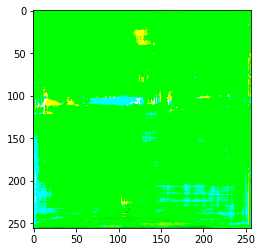

In [22]:
generator = Generator(use_t_conv=False)

gen_output = generator(m_inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])
print(gen_output.shape)

## Discriminator

In [23]:
def Discriminator():
    """Define discriminator network."""
    initializer = tf.random_normal_initializer(0.0, 0.02)
    
    inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
    
    x = tf.keras.layers.concatenate([inp, tar]) # (B, 256, 256, channels*2)
    
    down1 = downsample(64, 4, False)(x) # (B, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (B, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (B, 32, 32, 256)
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (B, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                 use_bias=False)(zero_pad1) # (B, 31, 31, 512)
    
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (B, 33, 512)
    
    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                 kernel_initializer=initializer)(zero_pad2) # (B, 30, 30, 1)
    
    return tf.keras.Model(inputs=[inp, tar], outputs=last)

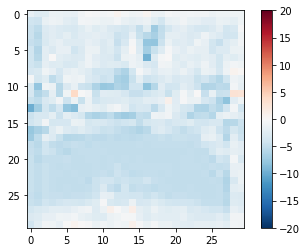

In [24]:
discriminator = Discriminator()
disc_out = discriminator([m_inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

## Loss

In [25]:
# L1 loss multiplying factor
LAMBDA = 100

In [26]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
def discriminator_loss(disc_r_output, disc_g_output):
    """Calculate the discriminator loss"""
    r_loss = loss_object(tf.ones_like(disc_r_output), disc_r_output)
    
    g_loss = loss_object(tf.zeros_like(disc_g_output), disc_g_output)
    
    total_loss = r_loss + g_loss
    
    return total_loss

In [28]:
def generator_loss(disc_g_output, gen_output, target):
    """Calculate the generator loss."""
    gan_loss = loss_object(tf.ones_like(disc_g_output), disc_g_output)
    
    # L1 error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    total_loss = gan_loss + (LAMBDA * l1_loss)
    
    return total_loss

In [29]:
# Define generator and discriminator optimizers
g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
d_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoint

In [30]:
checkpoint_dir = "./checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=g_optimizer,
                                discriminator_optimizer=d_optimizer,
                                generator=generator,
                                discriminator=discriminator)

manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

## Generate Test Images

In [31]:
def generate_images(model, input_im, target):
    """Generate and display images using the generator network."""
    prediction = model(input_im, training=True)
    plt.figure(figsize=(15,15))
    
    display_list = [input_im[0], target[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

## Pre Training Generator

In [32]:
def generator_pretrain_loss(gen_output, target):
    """Calculate the generator loss."""
    # L1 error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    return l1_loss

In [33]:
@tf.function
def gen_pretrain_step(input_image, target):
    """Pretrain."""
    with tf.device("/gpu:0"):
        with tf.GradientTape() as gen_tape:
            gen_output = generator(input_image, training=True)
            gen_loss = generator_pretrain_loss(gen_output, target)
            
        g_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        g_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))

In [34]:
def gen_pretrain(dataset, test_dataset):
    """Pre-train the generator network."""
    for input_image, target in dataset:
        gen_pretrain_step(input_image, target)
        
    clear_output(wait=True)
    for inp, tar in test_dataset.take(1):
        generate_images(generator, inp, tar)
        
    save_path = manager.save()

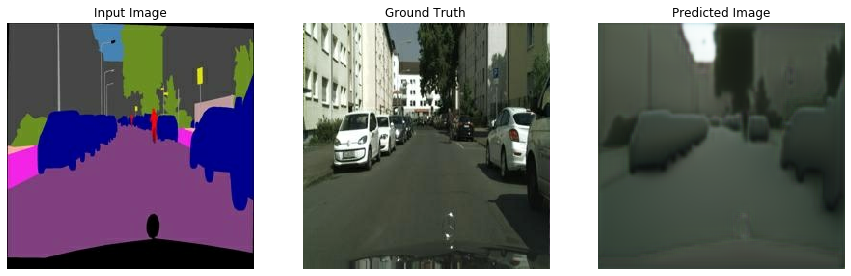

In [35]:
for i in range(8):
    gen_pretrain(train_dataset, test_dataset)

## Save and Create dataset from generated images.

In [36]:
def save_generated_images(dataset):
    """Save the generated images."""
    gen_path = dataset_path + "generated/"
    if os.path.exists(gen_path):
        shutil.rmtree(gen_path)
        
    os.mkdir(gen_path)
    
    for i, (input_image, target) in enumerate(dataset):
        gen_output = generator(input_image, training=False)
        
        for n, inp in enumerate(gen_output):
            final_image = tf.concat([input_image[n], target[n], inp], axis=1)
            final_image =  (final_image + 1) * 127.5
            final_image = tf.cast(final_image, tf.uint8)
            final_image = tf.constant(final_image).numpy()
            final_image = Image.fromarray(final_image)
            final_image.save(gen_path + str(i * 14 + n) + ".jpg")

In [37]:
def g_load_img(image_pth):
    """Load the image file."""
    image = tf.io.read_file(image_pth)
    image = tf.image.decode_jpeg(image)
    
    w = tf.shape(image)[1]
    w = w // 3
    
    real_img = image[:, :w, :]
    real_img = tf.cast(real_img, tf.float32)
    
    input_img = image[:, w:-w, :]
    input_img = tf.cast(input_img, tf.float32)
    
    gen_img = image[:, -w:, :]
    gen_img = tf.cast(gen_img, tf.float32)
    
    #return input_img, real_img
    return real_img, input_img, gen_img


# Normalize [-1, 1]
def g_normalize(input_img, real_img, gen_img):
    input_img = (input_img / 127.5) - 1.0
    real_img = (real_img / 127.5) - 1.0
    gen_img = (gen_img / 127.5) - 1.0
    
    return input_img, real_img, gen_img


# tf.function add the function to graph so can be run on GPU or TPU
@tf.function()
def g_random_jitter(input_img, real_img, gen_img):
    """Data augmentation for the photos."""
    input_img, real_img, gen_img = g_random_crop(input_img, real_img, gen_img)
    
    # Mirroring with chance of 0.5
    if tf.random.uniform(()) > 0.5:
        input_img = tf.image.flip_left_right(input_img)
        real_img = tf.image.flip_left_right(real_img)
        gen_img = tf.image.flip_left_right(gen_img)
        
    return input_img, real_img, gen_img


def g_random_crop(input_img, real_img, gen_img):
    """Randomly crop the image."""
    stacked_img = tf.stack([input_img, real_img, gen_img], axis=0)
    cropped_img = tf.image.random_crop(stacked_img, size=[3, img_height, img_width, 3])
    
    return cropped_img[0], cropped_img[1], cropped_img[2]

In [38]:
def load_img_generated(img_file):
    """Load and augment training images."""
    input_img, real_img, gen_img = g_load_img(img_file)
    input_img, real_img, gen_img = g_random_jitter(input_img, real_img, gen_img)
    input_img, real_img, gen_img = g_normalize(input_img, real_img, gen_img)
    
    return input_img, real_img, gen_img

In [39]:
def dataset_from_path(path):
    """Create a dataset from path."""
    dataset = tf.data.Dataset.list_files(path + '*.jpg')
    dataset = dataset.map(load_img_generated, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    
    return dataset

In [40]:
save_generated_images(train_dataset)

In [41]:
gen_dataset = dataset_from_path(dataset_path + "generated/")
gen_dataset

<DatasetV1Adapter shapes: ((None, 256, 256, 3), (None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32, tf.float32)>

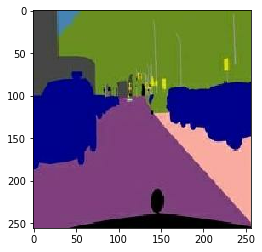

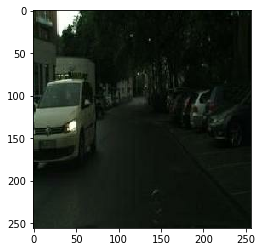

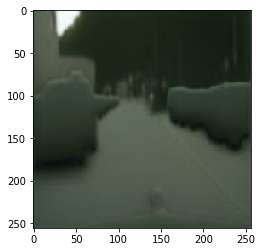

In [42]:
inp, re, gen = g_load_img(dataset_path + "generated/1.jpg")


plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)
plt.figure()
plt.imshow(gen/255.0)

## Pretrain discriminator

In [43]:
@tf.function
def disc_pretrain_step(input_image, target, generated):
    """Pretrain step for discriminator."""
    with tf.device("/gpu:0"):
        with tf.GradientTape() as disc_tape:
            disc_real_output = discriminator([input_image, target], training=True)
            disc_generated_output = discriminator([input_image, generated], training=True)
            
            disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
            
        d_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

In [44]:
def disc_pretrain(dataset):
    """Pretrain discriminator."""
    for input_image, target, generated in dataset:
        disc_pretrain_step(input_image, target, generated)
        
    save_path = manager.save()

In [45]:
for i in range(4):
    disc_pretrain(gen_dataset)

W0814 18:06:53.653544 17784 deprecation.py:323] From C:\Users\rMiladilari\AppData\Local\Continuum\anaconda3\envs\ml\lib\site-packages\tensorflow\python\ops\nn_impl.py:182: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Training Step

In [46]:
@tf.function
def train_step(input_image, target):
    """Train for one epoch."""
    with tf.device("/gpu:0"):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_output = generator(input_image, training=True)
        
            disc_real_output = discriminator([input_image, target], training=True)
            disc_generated_output = discriminator([input_image, gen_output], training=True)
        
            gen_loss = generator_loss(disc_generated_output, gen_output, target)
            disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        
        g_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        d_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
        g_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))
        d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

In [47]:
def train(dataset, test_dataset, epochs):
    """Training loop."""
    for epoch in range(epochs):
        start = time.time()
        
        dataset = dataset.shuffle(buffer_size)
        test_dataset = test_dataset.shuffle(buffer_size)
        
        for input_image, target in dataset:
            #print(input_image.shape)
            train_step(input_image, target)
        
        clear_output(wait=True)
        for inp, tar in test_dataset.take(1):
            generate_images(generator, inp, tar)
            
        if (epoch + 1) % 20 == 0:
            save_path = manager.save()
            
        print('Training took {} seconds for epoch {}\n'.format(time.time()-start, epoch+1))

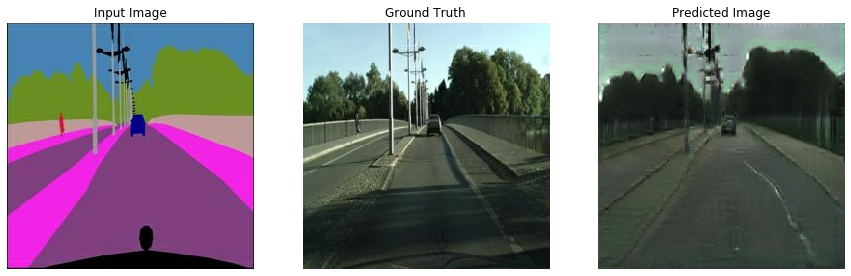

Training took 126.99203610420227 seconds for epoch 150



In [48]:
train(train_dataset, test_dataset, 150)

## Loading the model

In [49]:
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Checkpoint Restored from {}".format(manager.latest_checkpoint))
else:
    print("Couldn't restore from checkpoint.")

Checkpoint Restored from ./checkpoints\ckpt-19


## Test the model

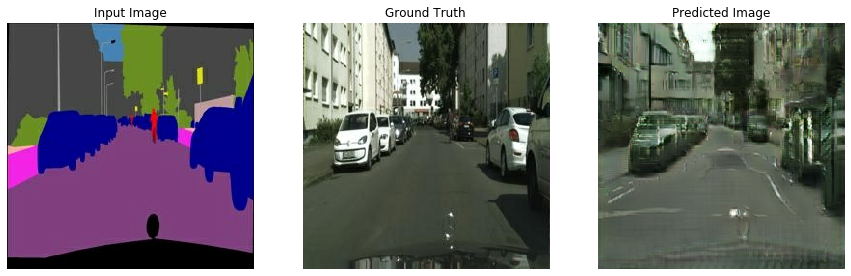

In [50]:
for inp, tar in test_dataset.take(1):
    generate_images(generator, inp, tar)